# Importing and Fetching Data

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from stonks_modules import *

plt.rcParams["figure.dpi"] = 300

# The ticker for State Bank of India on the National Stock Exchange
ticker_symbols = ["SBIN.NS", "PNB.NS"]
sbi = yf.Ticker(ticker_symbols[0])
tickers = {symbol:yf.Ticker(symbol) for symbol in ticker_symbols}


In [38]:
hourly_data_files = {ticker_symbol: fetch_and_save_data(ticker)[0] for ticker_symbol, ticker in tickers.items()}
hourly_dataframes = {ticker_symbol: pd.read_csv(filename) for ticker_symbol, filename in hourly_data_files.items()}
hourly_closes = {ticker_symbol: df[["Close"]] for ticker_symbol, df in hourly_dataframes.items()}

Success! Saved 5069 rows of hourly data to 'SBIN.NS_Hourly_Data.csv'.
Success! Saved 1237 rows of daily data to 'SBIN.NS_5Year_Daily_Data.csv'.
Success! Saved 5069 rows of hourly data to 'PNB.NS_Hourly_Data.csv'.
Success! Saved 1237 rows of daily data to 'PNB.NS_5Year_Daily_Data.csv'.


In [36]:
baseline_profits = {}

for ticker_symbol, close_df in hourly_closes.items():
    first_close = close_df.iloc[0]   # keeps same behavior as your original code (Series)
    last_close = close_df.iloc[-1]
    baseline_profits[ticker_symbol] = (100 / first_close) * last_close

# Basic Strategy Definition

In [35]:
from numba import njit

# Use Numba's "Just-In-Time" compiler to turn this into C-speed code
@njit
def fast_trading_strategy(prices, buy_multiplier, sell_multiplier, indexes_to_wait_before_buying_again = 5):
    current_money = 100.0
    current_stocks = 0.0
    bought_or_sold_price = prices[0]
    current_stocks += current_money / bought_or_sold_price
    current_money = 0.0
    last_index_for_sell = 0

    long_position = True

    for i in range(1, len(prices)):
        current_price = prices[i] # Accessing the raw array is incredibly fast
        
        # Sell Signal
        if long_position:
            if current_price >= (sell_multiplier * bought_or_sold_price):
                current_money += current_stocks * current_price
                long_position = False
                current_stocks = 0.0
                bought_or_sold_price = current_price
                last_index_for_sell = i
                
        # Buy Signal
        else:
            if (current_price <= (buy_multiplier * bought_or_sold_price)) or (i - last_index_for_sell >= indexes_to_wait_before_buying_again):
                current_stocks += current_money / current_price
                long_position = True
                current_money = 0.0
                bought_or_sold_price = current_price

    if current_money == 0.0:
        current_money = current_stocks * prices[-1]

    return current_money

# Creating the Heatmap's data

In [5]:
sell_multipliers = np.round(np.arange(1.001, 1.11, 0.001), 3)
buy_multipliers = np.round(np.arange(0.999, 0.889, -0.001), 3)

print(f"Length of Sell Multipliers: {len(sell_multipliers)}")
print(f"Length of Buy Multipliers: {len(buy_multipliers)}")
profits_matrix = np.zeros((len(buy_multipliers), len(sell_multipliers)))

x_tick_distance = len(sell_multipliers) // 5
y_tick_distance = len(buy_multipliers) // 5

Length of Sell Multipliers: 110
Length of Buy Multipliers: 110


In [6]:
def backtest_grid(sbi_hourly, buy_multipliers, sell_multipliers, wait_before_buying_again) -> np.ndarray:
    profits_matrix = np.zeros((len(buy_multipliers), len(sell_multipliers)))

    for i, buy_mult in enumerate(tqdm(buy_multipliers, desc="Backtesting Grid")):    
        for j, sell_mult in enumerate(sell_multipliers):

                # Run the backtest for this specific combination
                final_value = fast_trading_strategy(sbi_hourly["Close"].values, buy_mult, sell_mult, wait_before_buying_again)
                
                # Store the result
                profits_matrix[i, j] = final_value

    return profits_matrix

# Creating the Heatmap

Backtesting Grid: 100%|██████████| 110/110 [00:00<00:00, 1113.26it/s]
/var/folders/f6/knv67x010rd1hcv02ryxvd2w0000gn/T/ipykernel_30800/370540180.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


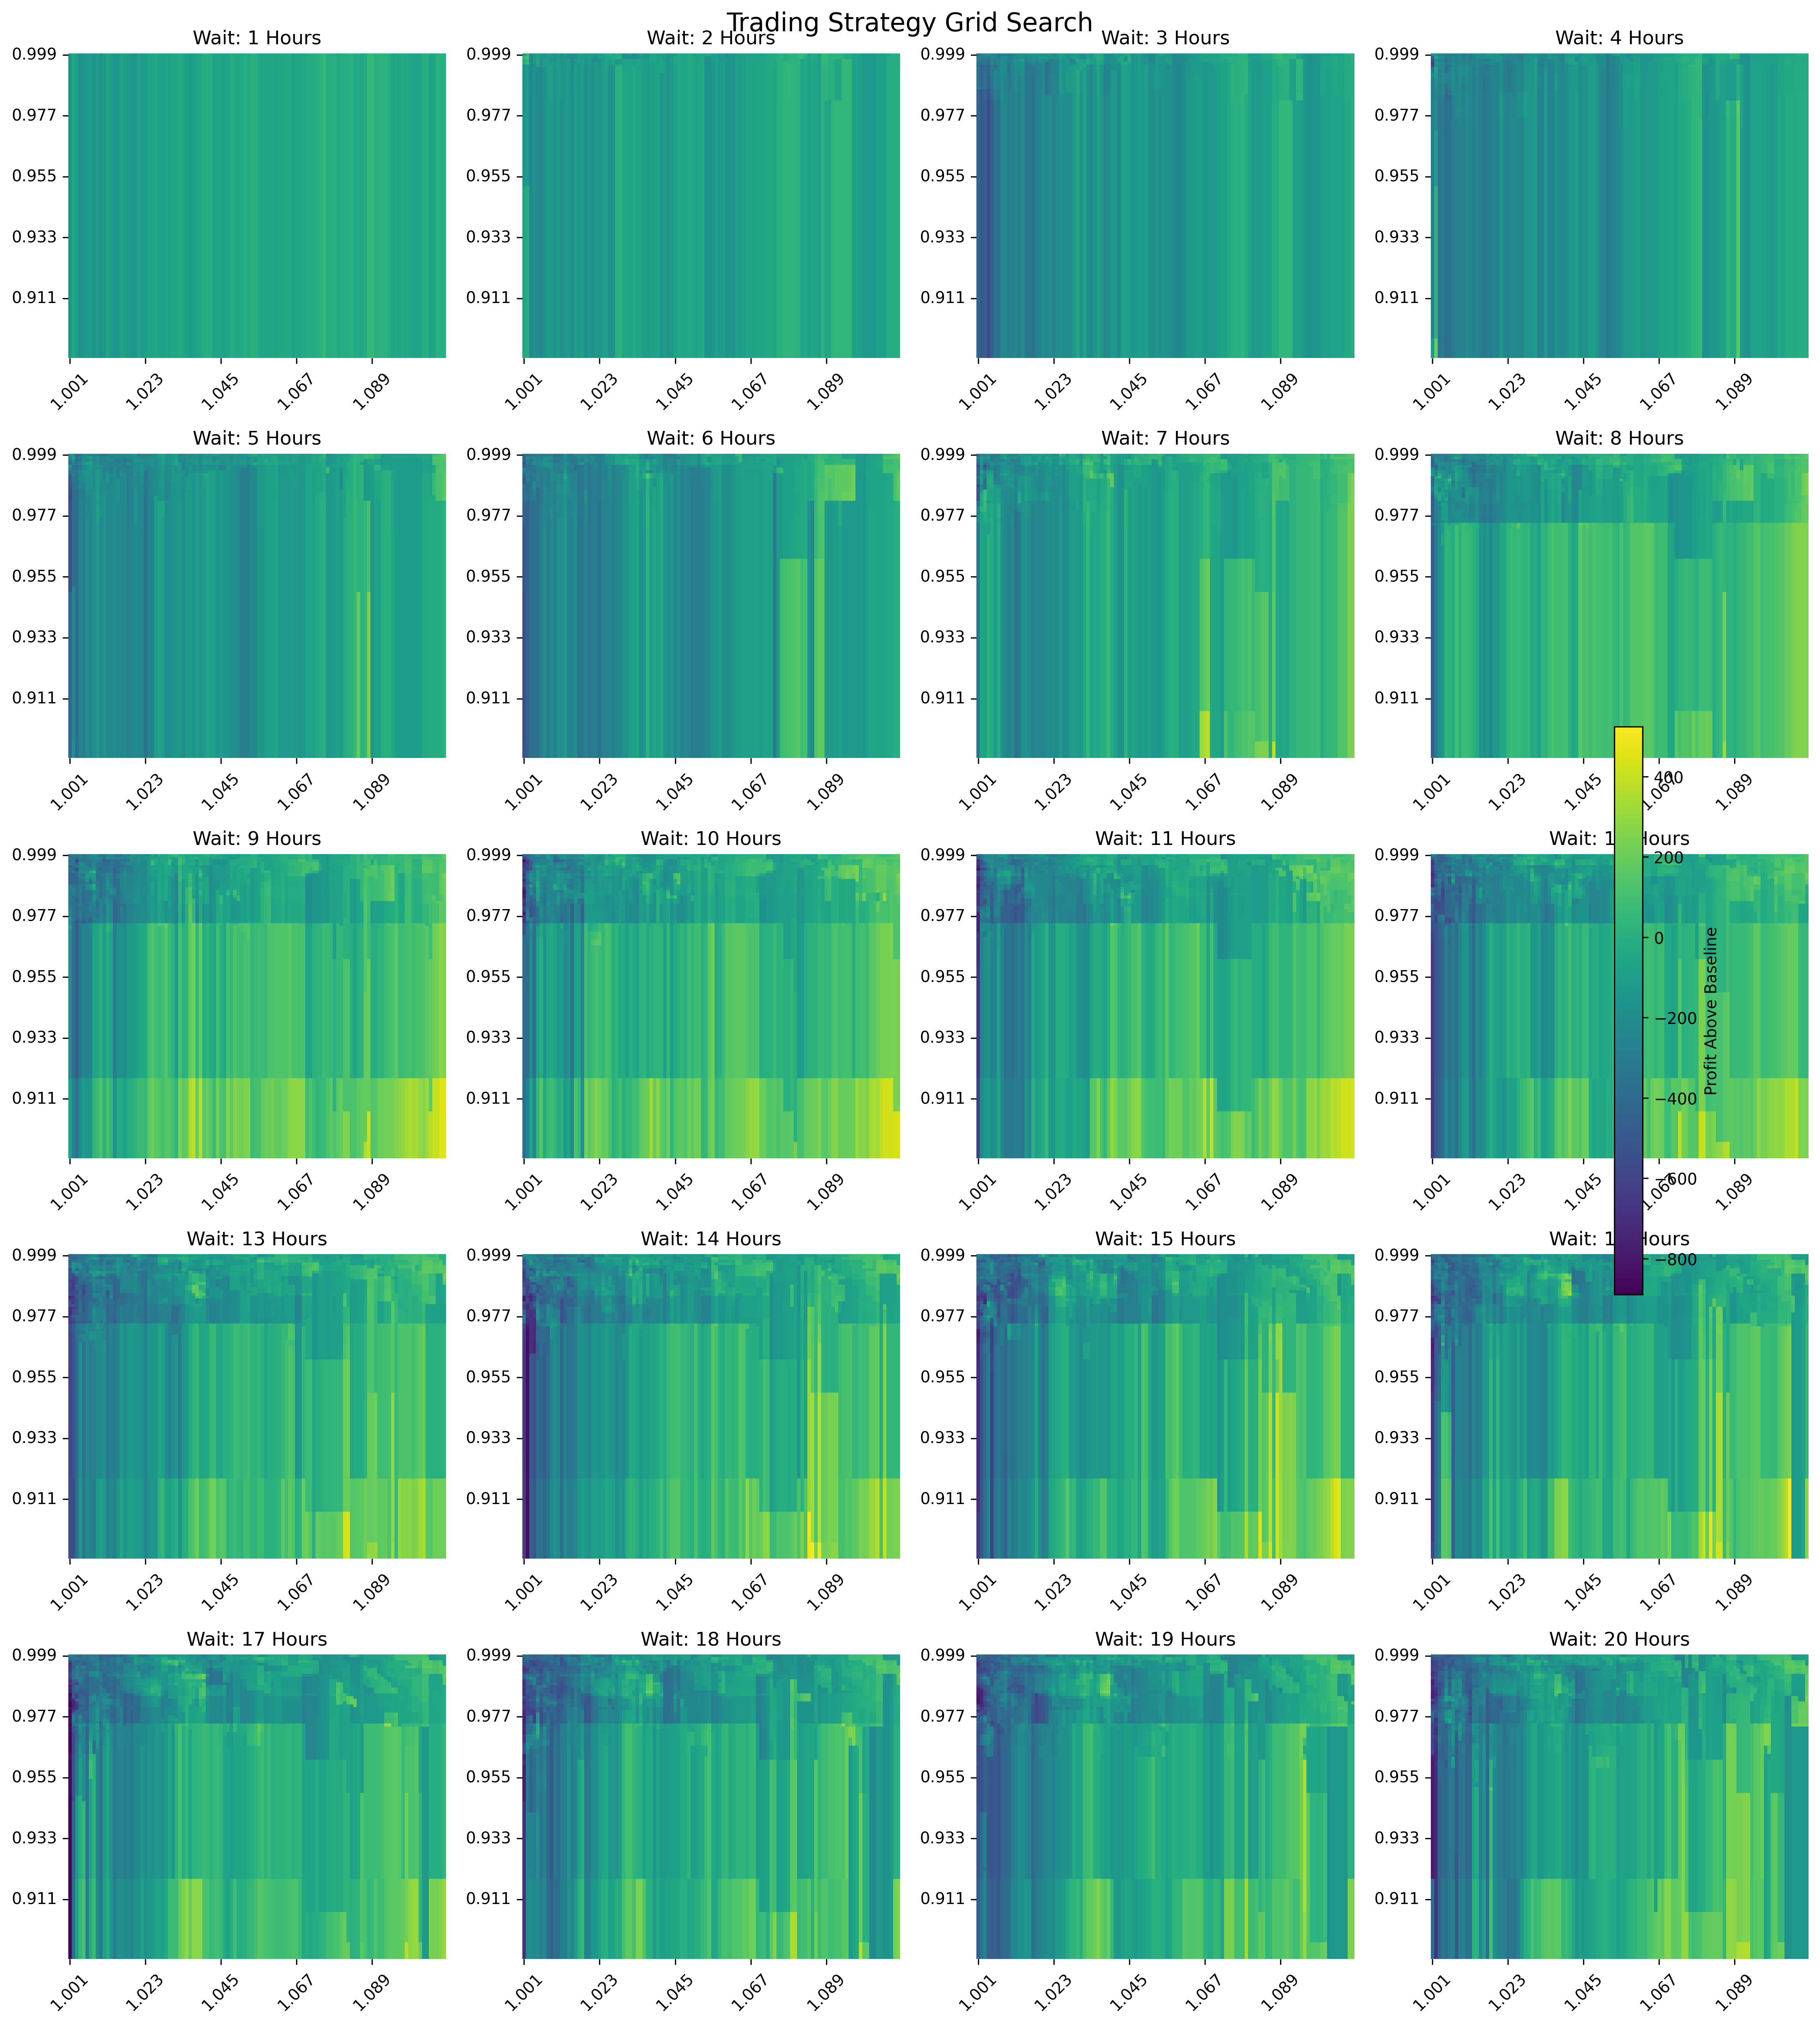

In [11]:
data_list = []

for wait in range(1, 21):
    profits_matrix = backtest_grid(sbi_hourly, buy_multipliers, sell_multipliers, wait)
    new_profits_matrix = profits_matrix - baseline_profit
    # new_profits_matrix = np.clip(new_profits_matrix, a_min=0, a_max=None)

    data_list.append(new_profits_matrix)

vmin = min(d.min() for d in data_list)
vmax = max(d.max() for d in data_list)

fig, axes = plt.subplots(5, 4, figsize=(16, 18))

# 1. Pass the actual NumPy arrays to the label arguments
for idx, ax in enumerate(axes.flat):
    sns.heatmap(data_list[idx], 
                annot=False, 
                cmap='viridis',
                xticklabels=sell_multipliers,
                yticklabels=buy_multipliers,
                ax=ax,
                cbar=False,
                vmin=vmin,
                vmax=vmax
                )  # remove colorbar to avoid 20 of them

    # 2. Thin out the labels: Get the current tick locations, and only keep every 10th tick
    ax.set_xticks(ax.get_xticks()[::x_tick_distance])
    ax.set_xticklabels(sell_multipliers[::x_tick_distance], rotation=45) # Rotate x-labels slightly for readability

    ax.set_yticks(ax.get_yticks()[::y_tick_distance])
    ax.set_yticklabels(buy_multipliers[::y_tick_distance], rotation=0)
    
    ax.set_title(f"Wait: {idx+1} Hours")

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="viridis",
                          norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.02
)

cbar.set_label("Profit Above Baseline")

# Add clear titles
fig.suptitle("Trading Strategy Grid Search", fontsize=16)

plt.tight_layout()
plt.savefig("heatmaps.png", dpi=600, bbox_inches="tight")
plt.show()

Backtesting Grid: 100%|██████████| 110/110 [00:00<00:00, 1530.93it/s]


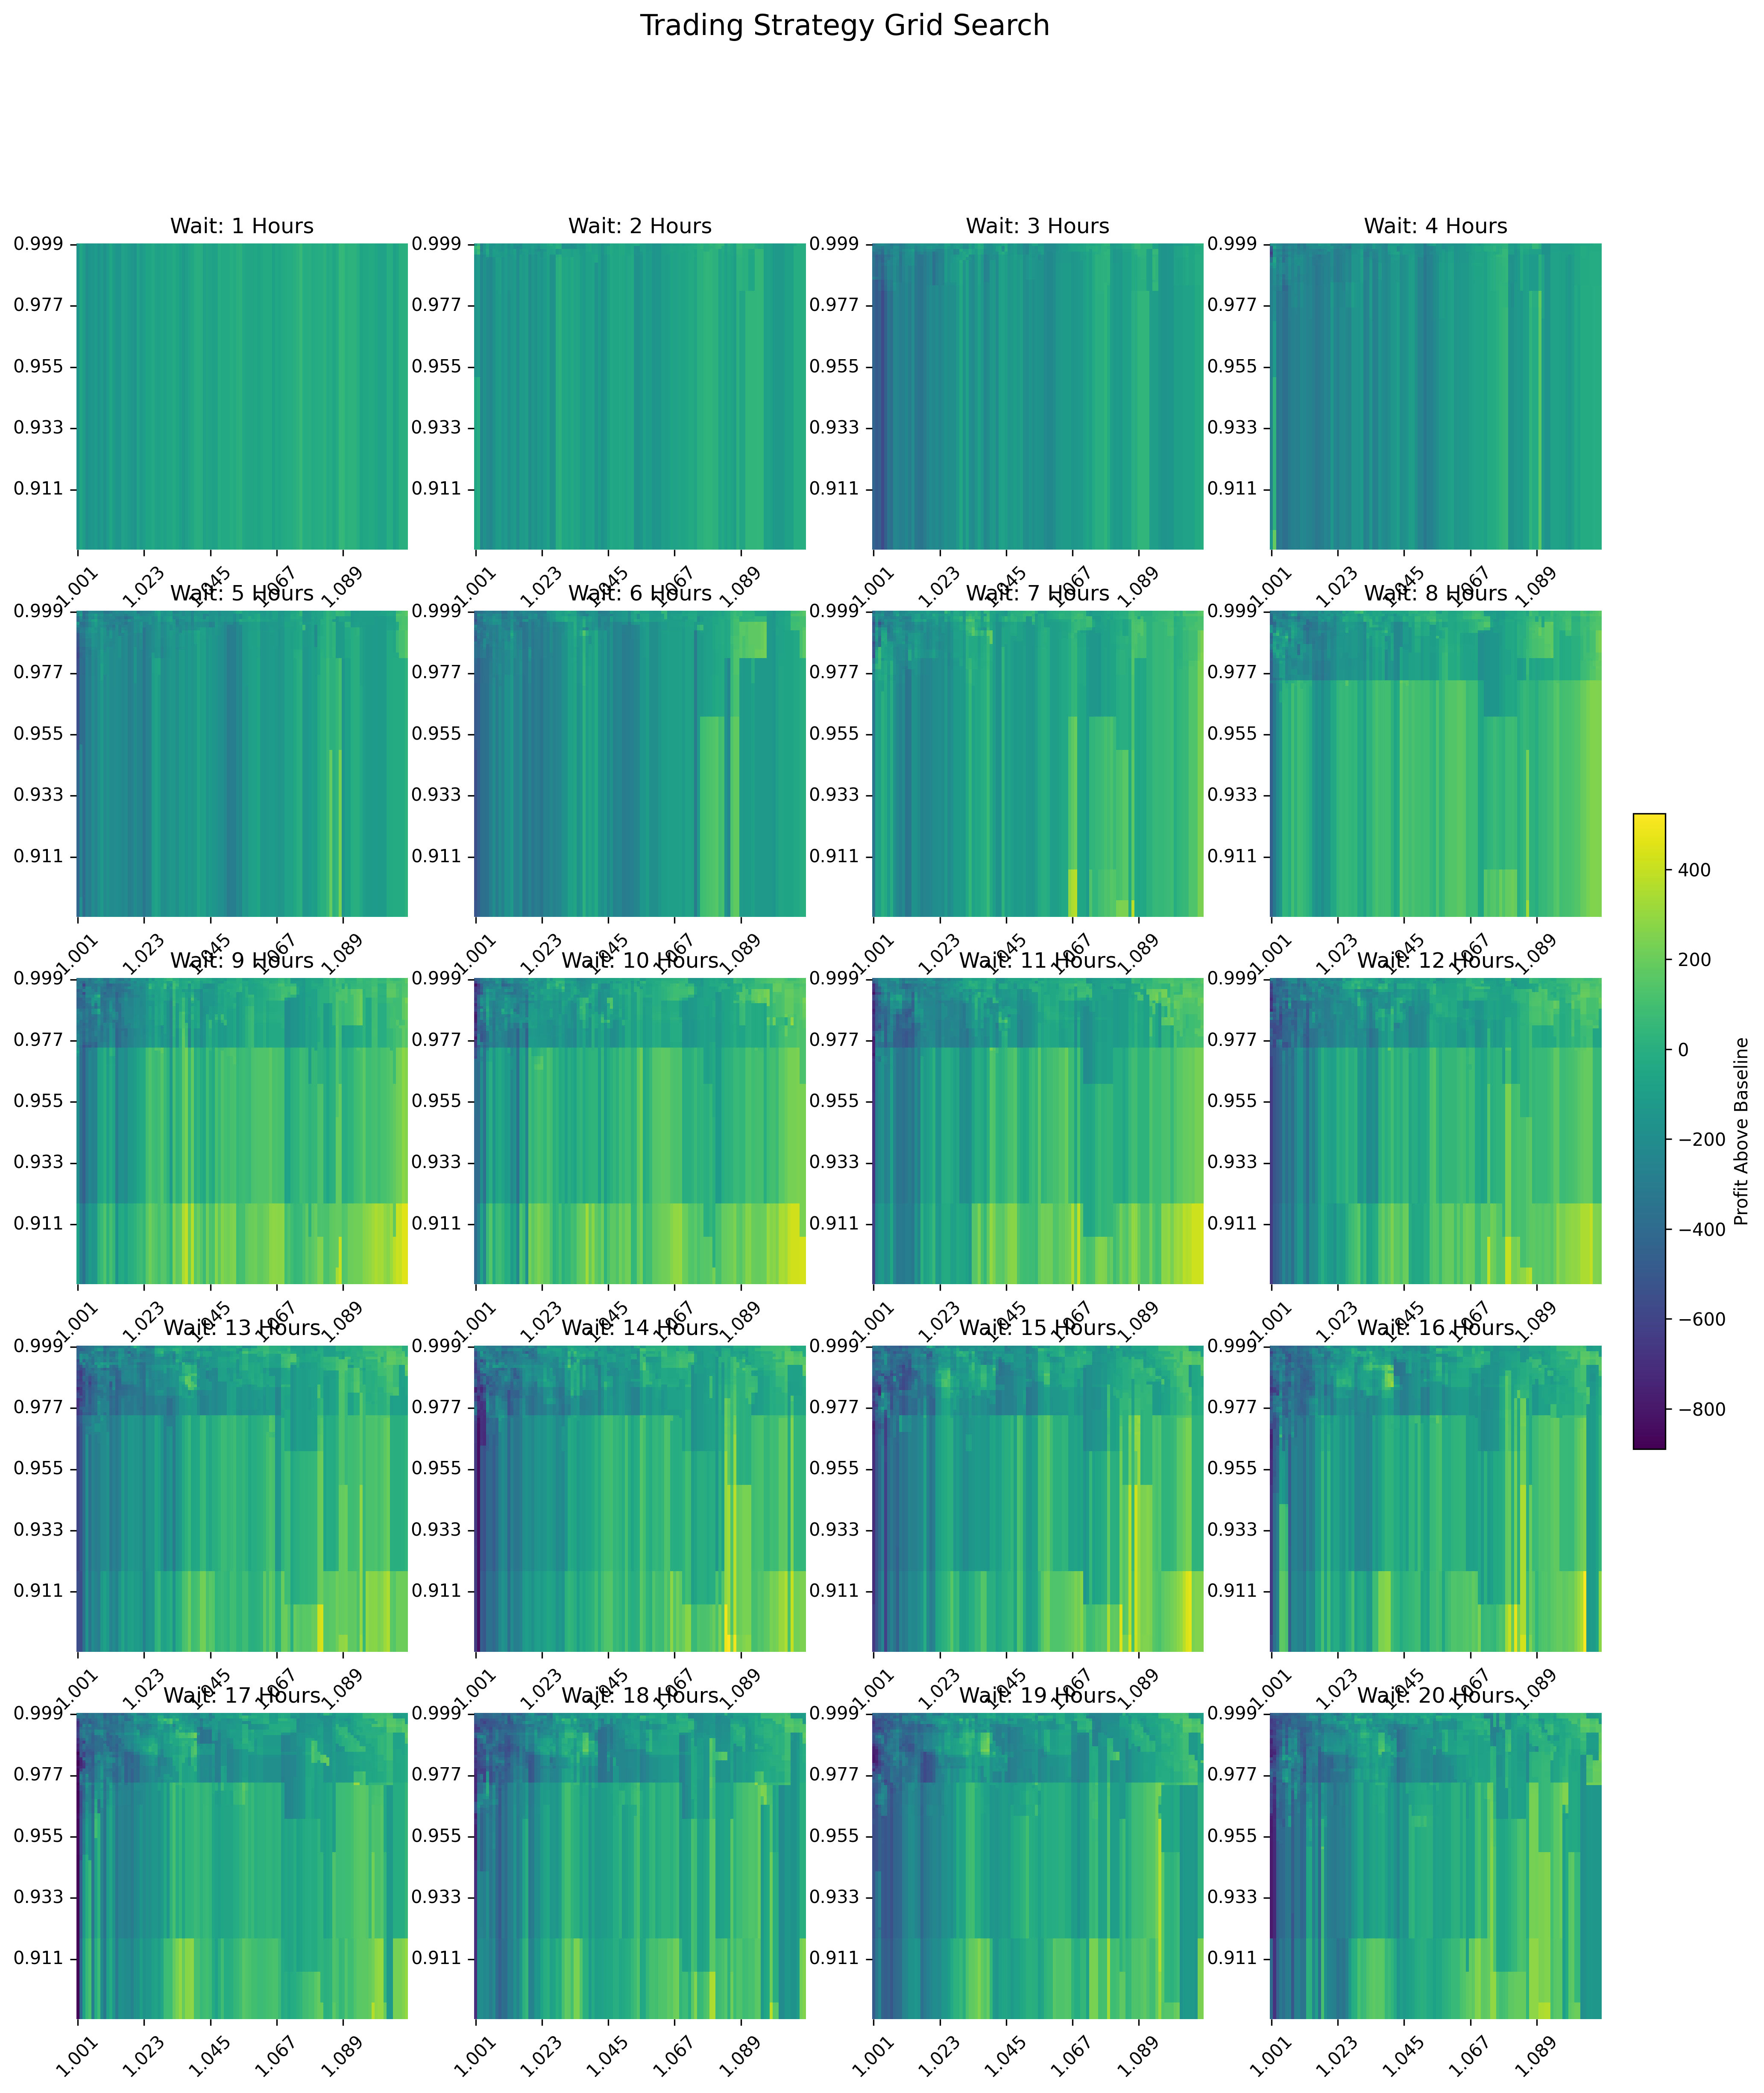

In [13]:
data_list = []
for wait in range(1, 21):
    profits_matrix = backtest_grid(sbi_hourly, buy_multipliers, sell_multipliers, wait)
    new_profits_matrix = profits_matrix - baseline_profit
    data_list.append(new_profits_matrix)

vmin = min(d.min() for d in data_list)
vmax = max(d.max() for d in data_list)

fig, axes = plt.subplots(5, 4, figsize=(16, 18), dpi=300)

for idx, ax in enumerate(axes.flat):
    sns.heatmap(
        data_list[idx],
        ax=ax,
        cmap="viridis",
        cbar=False,
        vmin=vmin,
        vmax=vmax
    )

    ax.set_xticks(np.arange(0, len(sell_multipliers), x_tick_distance) + 0.5)
    ax.set_xticklabels(sell_multipliers[::x_tick_distance], rotation=45)

    ax.set_yticks(np.arange(0, len(buy_multipliers), y_tick_distance) + 0.5)
    ax.set_yticklabels(buy_multipliers[::y_tick_distance], rotation=0)

    ax.set_title(f"Wait: {idx+1} Hours")

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.02
)
cbar.set_label("Profit Above Baseline")

fig.suptitle("Trading Strategy Grid Search", fontsize=16)

plt.savefig("heatmaps.png", dpi=600, bbox_inches="tight")
plt.show()